In [46]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import re
import matplotlib.pyplot as plt
%matplotlib inline
import my_speller
import imp
imp.reload(my_speller)
from autocorrect import spell as spell_eng

import pygtrie as trie

from scipy.optimize import curve_fit

from tqdm import tqdm_notebook

from scipy import statsts

Загрузка датасета

In [2]:
client_mess = pd.read_csv('Client_messages_cleaned.csv', encoding='Windows-1251', delimiter=';', header=None)

In [3]:
client_mess.head(60)

,0,1
0,2,"Я внес деньги на карту. Когда они придут, я их..."
1,4,Кредитная
2,6,По карте
3,8,Да
4,10,Да
5,17,"ООО, вас чат появился"
6,19,Прикольное
7,21,А баланс можете сказать
8,22,"А нет, не надо"
9,23,А до # Name вы работаете


Создадим векторизатор

In [4]:
CV = CountVectorizer(ngram_range=(1,1))

Модуль исправления ошибок

In [5]:
fn_dict = 'data/word_freq_dict.csv.zip'
fn_letters = 'data/letter_typos_matrix.json'
fn_typical = 'data/typical_typos.json'
fn_bigrams = 'data/bigrams.zip'
speller = my_speller.Speller(fn_dict, fn_letters, fn_typical, fn_bigrams, fix_register=True, verbose=False, try_split=True)

Запустим CountVectorizer на клиентских сообщениях.

In [6]:
%%time
cnt = CV.fit_transform(client_mess[1].dropna())

Wall time: 14.8 s


In [7]:
cnt.shape

(812312, 74916)

Выделим все слова и подсчитаем суммарное количество упоминаний во всех сообщениях

In [8]:
%%time
# Все слова
features = CV.get_feature_names()
# Суммарное упоминание каждого слова во всех сообщениях
total_count = np.array(np.sum(cnt, axis=0))

Wall time: 151 ms


Датафрейм с парами слов и количеством появлений

In [9]:
w = pd.DataFrame({'word':features, 'count':total_count.reshape(-1)})
w.to_csv('All_words.csv', encoding='Windows-1251')

In [10]:
w.head(60)

,count,word
0,1,aaa
1,2,aaaa
2,1,aadroid
3,1,aarbekovich
4,1,aastasia
5,3,aaр
6,13,ab
7,5,aba
8,1,abdaily
9,2,abdukarim


Уберем слишком редкие слова

In [11]:
w = w[w['count']>20]

Убираем слова, неизвестные спеллчекеру

In [12]:
w['is_known'] = w['word'].apply(speller._word_is_known)

In [13]:
w.dropna(inplace=True)

In [14]:
w.to_csv('known_words.csv', encoding='Windows-1251')

In [16]:
w.shape

(9031, 3)

In [16]:
w = pd.read_csv('known_words.csv', encoding='cp1251')

In [17]:
w.head()

,Unnamed: 0,count,word,is_known
0,29,26,account,account
1,43,36,ad,ad
2,128,25,aliexpress,aliexpress
3,149,39,am,am
4,154,23,ame,ame


In [18]:
cnt1 = w.sort_values(['count'], ascending=False)['count']

Just for fun: проверим закон Ципфа для клиентских сообщений

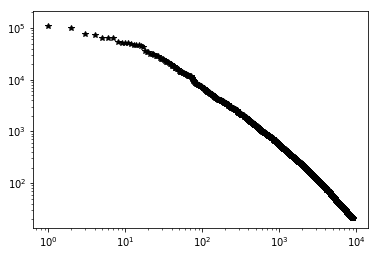

In [19]:
plt.plot(np.arange(0, len(cnt1)), cnt1.values, 'k*')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

In [62]:
def power_law_func(x, C, alpha):
    return C * np.power(x, alpha)
x = np.arange(1, len(cnt1) + 1)
for i in tqdm_notebook(range(10)):
    p0 = [np.random.uniform(0, 100, 1)[0], np.random.uniform(-0.1, -1.0, 1)[0]]
    popt, pcov = curve_fit(power_law_func, x[500:], cnt1.values[500:], p0 = p0)
    print(p0, popt)

A Jupyter Widget

[42.162120662808952, -0.9643731104187061] [  4.81389216e+06  -1.31756879e+00]
[1.7163330572504965, -0.24383010678715025] [  4.81391352e+06  -1.31756944e+00]
[47.070484733147545, -0.60921985612391993] [  4.81390328e+06  -1.31756913e+00]
[80.713963308542432, -0.65908268846464357] [  4.81389914e+06  -1.31756900e+00]
[9.1633796520848581, -0.54615317770616945] [  4.81390174e+06  -1.31756908e+00]
[20.922073130689324, -0.23431764707305169] [  4.81389010e+06  -1.31756873e+00]
[6.0568632390362032, -0.65398355092569638] [  4.81388986e+06  -1.31756872e+00]
[15.530094392134508, -0.86816895326062105] [  4.81391397e+06  -1.31756946e+00]
[31.1015703964738, -0.34679437401783469] [  4.81390220e+06  -1.31756910e+00]
[93.38260083696369, -0.66390503238461163] [  4.81390317e+06  -1.31756913e+00]



In [63]:
pcov
len(cnt1)

9031

Text(0.5,1,'Kolomogorov-Smirnov test pvalue=1.000000')

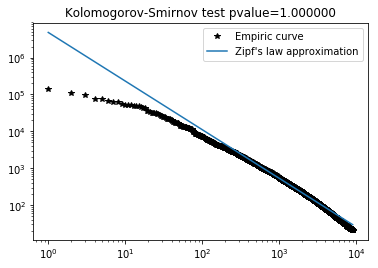

In [65]:
D, pvalue = stats.kstest(cnt1.values[500:], power_law_func, args=popt, alternative='greater')
plt.plot(x, cnt1.values, 'k*')
plt.plot(x, power_law_func(x, *popt))
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.legend(['Empiric curve', 'Zipf\'s law approximation'])
plt.title('Kolomogorov-Smirnov test pvalue=%f'%pvalue)

Словарь нецензурной лексики (от Дайховской). Приводим к нижнему регистру, чтобы сравнивать 

In [45]:
obsc = pd.read_table('obscene_corpus.txt', header=None)
obsc[0] = obsc[0].apply(str.lower)

In [46]:
obsc.head()

,0
0,6ля
1,6ляд
2,fuck
3,pizd
4,pizda


In [48]:
'бля' in obsc.values

True

In [49]:
is_obsc = lambda x: x in obsc.values
w['obsc'] = w['word'].apply(is_obsc)

In [50]:
w[w.obsc == True]

,count,word,is_known,obsc
9425,22,бля,бля,True
72308,31,хуй,хуй,True


In [51]:
w = w[w.obsc == False]

In [52]:
t = trie.CharTrie()

In [ ]:
import pygtrie as trie
t = trie.CharTrie()
for word, count in zip(w.word.values, w['count'].values):
    t[word] = count
import pickle
with open('trie_words.pkl', 'wb') as f:
    pickle.dump(t, f)

Внесем все слова в префиксное дерево

In [53]:
for word, count in zip(w.word.values, w['count'].values):
    t[word] = count

In [177]:
t.has_subtrie('здравст')

True

Тест обхода по дереву с целью выявить наиболее частое слово.

Однозначно нужно ставить shallow=False при обходе. В обратном случае, если префикс является словом, то будет возвращен именно он, и дальше обход дерева не пойдет. Есть большой шанс потерять более длинные и при этом более частые слова. Например, слово *бан* встречается 25 раз, слово *банк* - 19000, но по запросу *бан* выдается слово *бан*

In [145]:
%%time
best_choice = ''
best_count = 0
pref = 'бан'
num_vars = 10

if t.has_subtrie(pref):
    for key, value in t.iteritems(pref, shallow=False):
        #print(key, value)
        if value > best_count:
            best_choice = key
            best_count = value
else:
    print('Префикс отсутствует')

Wall time: 1 ms


In [171]:
%%time
best_choice = ''
best_count = 0
pref = 'са'
num_vars = 10

if t.has_subtrie(pref):
    s = [x[0] for x in sorted(list(t.iteritems(pref, shallow=False)), key=lambda x:x[1], reverse=True)[0:num_vars]]

Wall time: 1 ms


In [169]:
s

['банк',
 'банка',
 'банке',
 'банкомат',
 'баланс',
 'банком',
 'банкомате',
 'банку',
 'банках',
 'банкомата']

Как должен работать класс:

* Поступает на вход полная строка из того, что пользователь уже ввел
* Если она кончается на пробел или символ конца строки, то предлагаем варианты нового слова
* Если нет, то ищем вариант дописывания. Если варианты отсутствуют, то предлагаем варианты нового слова.

In [268]:
from lazy import lazy
from collections import Counter

class Autofill():
    def __init__(self, trie, bigrams_filename, num_vars=10):
        self.trie = trie
        self.bigrams_filename = bigrams_filename
        self.num_vars = num_vars
        
    def __call__(self, s):
        last_word = self.get_last_word(s)
        if self.is_new_word(s):
            res = self.get_new_word(last_word)
        else:
            res = self.get_continuation(last_word)
        return res

    @lazy
    def bigrams(self):
        df = pd.read_csv(self.bigrams_filename, encoding='cp1251')
        bigrams = dict()
    #    total_word_entries = df.num.sum()
        for w1, w2, n in zip(df.word1, df.word2, df.num):
            bigrams[w1] = bigrams.get(w1, dict())
            bigrams[w1][w2] = n #/ total_word_entries
        for w1 in bigrams:
            bigrams[w1] = [w for w, n in Counter(bigrams[w1]).most_common(self.num_vars)]
        return bigrams
            
    # Последнее слово в строке
    #self.last_word = s.rstrip().rsplit(' ', maxsplit=1)[-1]
    def get_last_word_old(self, s):
        s = s.rstrip()
        i = len(s) - 1 
        is_started = False
        is_ended = False
        i_start = 0
        i_end = i
        while not is_ended:
            if not is_started:
                if s[i].isalpha():
                    is_started = True
                    i_end = i
                i-=1
                continue
            else:
                if s[i].isalpha():
                    i-=1
                    continue
                else:
                    i_start = i + 1
                    return s[i_start:i_end]
                
    def get_last_word(self, s):
        return s.split()[-1]

    def is_new_word(self, s):
        return s[-1] in [' ', '\n']

    def get_new_word(self, s):
        return self.bigrams.get(s)
        
    
    def get_continuation(self, pref):
        # Принимаем на вход начало слова, возвращаем варианты следующего слова, отсортированные по убыванию частоты
        # Если не нашлось, возвращаем None и переходим в классе к возвращению нового слова
        if self.trie.has_subtrie(pref):
            s = [x[0] for x in sorted(list(self.trie.iteritems(pref, shallow=False)), key=lambda x:x[1], reverse=True)[0:self.num_vars]]
            return s
        else:
            return None


In [ ]:
autofill

In [235]:
import pickle
with open('trie_words.pkl', 'wb') as f:
    pickle.dump(t, f)


In [236]:
with open('trie_words.pkl', 'rb') as f:
    t = pickle.load(f)

In [274]:
autofill = Autofill(t, 'bigrams.csv')


In [283]:
autofill("вашем ")

['банке', 'сайте', 'же', 'отделении']

In [184]:
s = 'sdfkjl sdkfjlkwe wreupw    '
s.rstrip().rsplit(' ', maxsplit=1)[-1]

'wreupw'

In [155]:
s = 'sdfk dsfhjk %s'%chr(10)

In [156]:
s.split(' ')

['sdfk', 'dsfhjk', '\n']

In [154]:
chr(10)

'\n'

In [185]:
s = 'asc'
s[1].isalnum()

True

In [193]:
def get_last_word(s):
    s = s.rstrip()
    i = len(s) - 1 
    is_started = False
    is_ended = False
    i_start = 0
    i_end = i
    while not is_ended:
        if not is_started:
            if s[i].isalpha():
                is_started = True
                i_end = i
            i-=1
            continue
        else:
            if s[i].isalpha():
                i-=1
                continue
            else:
                i_start = i + 1
                return s[i_start:i_end]

In [208]:
%%time
s = 'sdkjfp woiurewop, lsdkfj, '
#print(get_last_word(s))

Wall time: 0 ns


In [199]:
import re

In [211]:
x = re.search('\w+', s)

In [212]:
print(x.)

None


In [216]:
%%time
s = 'sdkjfp woiurewop, lsdkfj, '
x = re.findall('\w+', s)[-1]


Wall time: 1 ms


In [ ]:
x.